# EDA for Data Analysis Project by Tianyi, Martine and Rami

## Project Description
Our project aims to track NBA players' movements (i.e what teams they played for) while tracking the year and their scoring performances. 
To do so, we collected data from https://www.basketball-reference.com ranging from 1995 to 2024 and used a code (thanks to Professor Bouyahya) to merge the tables and only keep the columns that are pertinent to our project. You can find this code in the repository.

# Part 1 - Codes and functions

In [33]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

In [34]:
df = pd.read_csv("nba_player_stats_C_Rami.csv")
df

,Player,Team,Points,Season
0,Luka Dončić,DAL,2370.0,2024
1,Shai Gilgeous-Alexander,OKC,2254.0,2024
2,Giannis Antetokounmpo,MIL,2222.0,2024
3,Jalen Brunson,NYK,2212.0,2024
4,Nikola Jokić,DEN,2085.0,2024
...,...,...,...,...
17808,Yinka Dare,NJN,0.0,1995
17809,Tom Hovasse,ATL,0.0,1995
17810,Rich King,SEA,0.0,1995
17811,Derrick Phelps,SAC,0.0,1995


In [35]:
df.shape

(17813, 4)

This function will get a player's data and put it into one smaller table (the player name is inputted by the user)

In [36]:
def get_player_stats(player_name, df):

    # Filter the dataset for the given player
    player_data = df[df['Player'].str.lower() == player_name.lower()]
    
    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return None
    
    # Sort by season
    player_data = player_data.sort_values(by='Season', ascending=True)
    
    # Print the table
    print(player_data)

    #Plotting the data
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=player_data['Season'], y=player_data['Points'], label=player_name)
    plt.xlabel("Season")
    plt.ylabel("Total Points")
    plt.title(f"Points per Season for {player_name}")
    plt.xticks(player_data['Season'].unique())
    plt.grid(True)
    plt.show()

This function will map the different cities that a player has played for, with the marker sizes being bigger for the cities with the best scoring performance for the player. To do so, we needed to sum up the total points scored in each city and scale marker size so that cities where the player scored more points have larger markers.

In [37]:
#Dictionary mapping NBA teams to cities and their approximate coordinates
team_city_mapping = {
    "ATL": ("Atlanta", -84.3885, 33.7501),
    "BOS": ("Boston", -71.0589, 42.3601),
    "BKN": ("Brooklyn", -73.9442, 40.6782),
    "CHA": ("Charlotte", -80.8431, 35.2271),
    "CHI": ("Chicago", -87.6298, 41.8781),
    "CLE": ("Cleveland", -81.6944, 41.4993),
    "DAL": ("Dallas", -96.7970, 32.7767),
    "DEN": ("Denver", -104.9903, 39.7392),
    "DET": ("Detroit", -83.0458, 42.3314),
    "GSW": ("San Francisco", -122.4194, 37.7749),
    "HOU": ("Houston", -95.3698, 29.7604),
    "IND": ("Indianapolis", -86.1581, 39.7684),
    "LAC": ("Los Angeles", -118.2437, 34.0522),
    "LAL": ("Los Angeles", -118.2437, 34.0522),
    "MEM": ("Memphis", -90.0490, 35.1495),
    "MIA": ("Miami", -80.1918, 25.7617),
    "MIL": ("Milwaukee", -87.9065, 43.0389),
    "MIN": ("Minneapolis", -93.2650, 44.9778),
    "NOP": ("New Orleans", -90.0715, 29.9511),
    "NYK": ("New York", -74.0060, 40.7128),
    "OKC": ("Oklahoma City", -97.5164, 35.4676),
    "ORL": ("Orlando", -81.3792, 28.5383),
    "PHI": ("Philadelphia", -75.1652, 39.9526),
    "PHX": ("Phoenix", -112.0740, 33.4484),
    "POR": ("Portland", -122.6765, 45.5152),
    "SAC": ("Sacramento", -121.4944, 38.5816),
    "SAS": ("San Antonio", -98.4936, 29.4241),
    "TOR": ("Toronto", -79.3832, 43.6532),
    "UTA": ("Salt Lake City", -111.8910, 40.7608),
    "WAS": ("Washington", -77.0369, 38.9072)
}

def plotcities(player_name, df):
    player_data = df[df['Player'].str.lower() == player_name.lower()]
    
    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return
    
    #Grouping points by team
    points_by_team = player_data.groupby("Team")["Points"].sum().reset_index()
    
    #Retrieving city coordinates and points
    cities = []

    for i, row in points_by_team.iterrows():
        team, points = row["Team"], row["Points"]
        if team in team_city_mapping:
            city, lon, lat = team_city_mapping[team]
            cities.append((city, lon, lat, points))

    if not cities:
        print(f"No mapped cities found for {player_name}.")
        return

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(cities, columns=['City', 'Longitude', 'Latitude', 'Points'])
    gdf['geometry'] = [Point(xy) for xy in zip(gdf['Longitude'], gdf['Latitude'])]
    gdf = gdf.set_geometry('geometry').set_crs(epsg=4326).to_crs(epsg=3857)

    #Scaling marker size based on points scored
    min_size, max_size = 50, 500  
    gdf['Marker Size'] = min_size + (gdf['Points'] - gdf['Points'].min()) / (
        gdf['Points'].max() - gdf['Points'].min()) * (max_size - min_size)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf.plot(ax=ax, markersize=gdf['Marker Size'], label=player_name)

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"Cities {player_name} Played For", fontsize=16)
    ax.set_axis_off()
    plt.show()


# Part 2 - Usage and Results of Functions 

          Player Team  Points  Season
9047  Jeremy Lin  GSW    76.0    2011
8144  Jeremy Lin  NYK   512.0    2012
7458  Jeremy Lin  HOU  1095.0    2013
6906  Jeremy Lin  HOU   890.0    2014
6269  Jeremy Lin  LAL   832.0    2015
5657  Jeremy Lin  CHO   914.0    2016
5203  Jeremy Lin  BRK   523.0    2017
4891  Jeremy Lin  BRK    18.0    2018
3780  Jeremy Lin  ATL   546.0    2019
3779  Jeremy Lin  2TM   707.0    2019
3781  Jeremy Lin  TOR   161.0    2019


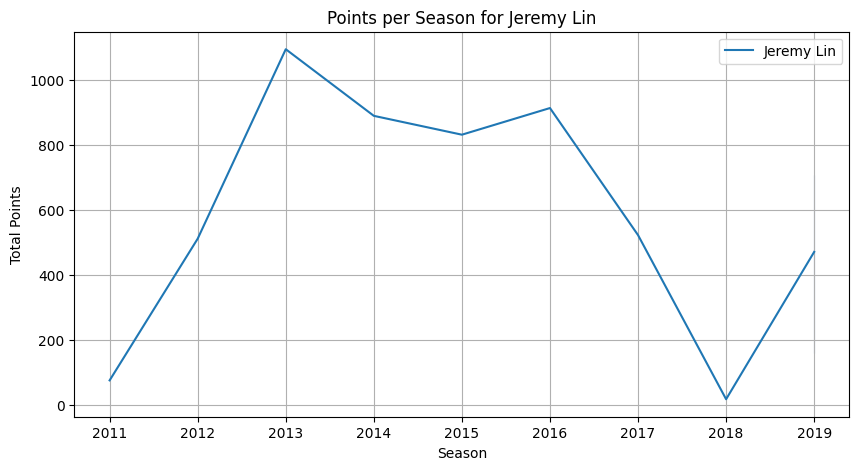

C:\Users\ramic\AppData\Local\Temp\ipykernel_38556\338578084.py:60: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf['geometry'] = [Point(xy) for xy in zip(gdf['Longitude'], gdf['Latitude'])]


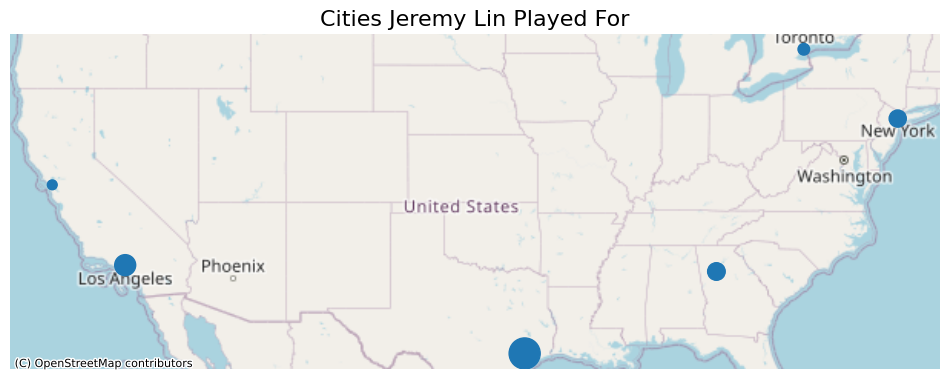

In [38]:
player_name = input("Enter player name: ")
get_player_stats(player_name, df)
plotcities(player_name, df)